In [ ]:
# Importar librerías necesarias
import os
import zipfile
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import keras

In [3]:
# -------------------------------
# Fijar semillas aleatorias para reproducibilidad
# -------------------------------
SEED = 5  # Semilla principal para reproducibilidad
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)  # Establece todas las semillas en TF 2.x

# Configurar operaciones para determinismo
tf.config.experimental.enable_op_determinism()

In [4]:

# -------------------------------
# 1. Extraer conjuntos de datos
# -------------------------------
zip_files = {
    'train': 'im_train.zip',
    'validation': 'im_validation.zip',
    'test': 'im_test.zip'
}

# Extracción de archivos ZIP si no existen
for folder, zip_file in zip_files.items():
    if not os.path.exists(folder):
        print(f"Extrayendo {zip_file} en la carpeta '{folder}/'...")
        with zipfile.ZipFile(zip_file, 'r') as z:
            z.extractall(folder)
        print("Extracción completada.")

In [ ]:
# Pesos de clases ajustados (modificado)
class_weight = {
    0: 1.5,    # fish (↓ de 1.8)
    1: 0.8,    # jellyfish
    2: 1.2,    # penguin (↓ de 1.3)
    3: 1.0,    # puffin
    4: 1.5,    # shark (↓ de 1.5)
    5: 1.2,    # starfish
    6: 1.2     # stingray (↓ de 1.3)
}

In [22]:
# -------------------------------
# 3. Definir configuraciones de entrenamiento
# -------------------------------
configurations = [
    {'learning_rate': 0.01, 'epochs': 20, 'fine_tune': True, 'unfreeze_layers': 5},
    #{'learning_rate': 0.0003, 'epochs': 50, 'fine_tune': True, 'unfreeze_layers': 25},
    #{'learning_rate': 0.001, 'epochs': 40, 'fine_tune': True, 'unfreeze_layers': 15}
]

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitoreamos la pérdida en validación
    factor=0.5,          # Reducimos la LR a la mitad cuando no mejora
    patience=3,          # Esperamos 3 épocas antes de reducir
    min_lr=1e-6          # Establecemos un límite mínimo para la LR
)

In [25]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    './train',
    image_size=(96, 96),
    batch_size=128,
    label_mode='categorical' 
)

val_dataset = image_dataset_from_directory(
    './validation',
    image_size=(96, 96),
    batch_size=128,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    './test',
    image_size=(96, 96),
    batch_size=128,
    label_mode='categorical',
    shuffle=False  # Para evaluar correctamente
)

Found 1113 files belonging to 7 classes.
Found 245 files belonging to 7 classes.
Found 238 files belonging to 7 classes.


In [31]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

# Hiperparámetros para cada modelo
learning_rates = [0.001, 0.005, 0.01]
dense_configs = [128, 128, 64]
epochs = [10, 5, 10]

input_size = 96
num_colors = 3
num_classes = 7

models = []
histories = []
log_dirs = []

for i in range(3):
    print(f"\nTraining model {i+1} with LR={learning_rates[i]}, Dense={dense_configs[i]}")

    # Cargar ResNet50 preentrenado
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(input_size, input_size, num_colors))

    # Fine-tuning: Descongelar solo algunas capas para los modelos 2 y 3
    if i >= 1:
        for layer in base_model.layers[:-20]:  # Congela todas menos las últimas 20 capas
            layer.trainable = False
        for layer in base_model.layers[-20:]:  # Permite entrenar las últimas 20 capas
            layer.trainable = True
    else:
        base_model.trainable = False  # En el primer modelo, no se entrena ResNet50

    # Arquitectura personalizada
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_configs[i], activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Optimización: RMSprop para modelo 1, SGD para modelos 2 y 3
    if i == 0:
        optimizer = RMSprop(learning_rate=learning_rates[i])
    else:
        optimizer = SGD(learning_rate=learning_rates[i], momentum=0.9, nesterov=True)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    log_dir = os.path.join("logs", f"model_{i+1}")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

    # Entrenamos el modelo
    history = model.fit(
        train_dataset,
        epochs=epochs[i],
        validation_data=val_dataset,
        callbacks=[
            tensorboard_callback,
            reduce_lr,
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
    )

    # Guardamos el modelo entrenado
    models.append(model)
    histories.append(history)
    log_dirs.append(log_dir)



Training model 1 with LR=0.001, Dense=128
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2707 - loss: 4.4685 - val_accuracy: 0.6612 - val_loss: 0.9490 - learning_rate: 0.0010
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6408 - loss: 0.9992 - val_accuracy: 0.7551 - val_loss: 0.7398 - learning_rate: 0.0010
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7596 - loss: 0.6967 - val_accuracy: 0.7673 - val_loss: 0.6327 - learning_rate: 0.0010
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8027 - loss: 0.5286 - val_accuracy: 0.7959 - val_loss: 0.5533 - learning_rate: 0.0010
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8537 - loss: 0.4454 - val_accuracy: 0.8041 - val_loss: 0.5820 - learning_rate: 0.0010
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8872 - loss: 0.3320 - val_accuracy: 0.8327 - val_loss: 0.5341 - learning_rate: 0.0010
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9015 - 

In [32]:

for i, hist in enumerate(histories):
    acc = hist.history['accuracy'][-1]
    val_acc = hist.history['val_accuracy'][-1]
    loss = hist.history['loss'][-1]
    val_loss = hist.history['val_loss'][-1]

    print(f"\n Modelo {i+1} :")
    print(f" - Accuracy (train):       {acc:.3f}")
    print(f" - Loss (train):           {loss:.3f}")
    print(f" - Accuracy (validation):  {val_acc:.3f}")
    print(f" - Loss (validation):      {val_loss:.3f}")


 Modelo 1 :
 - Accuracy (train):       0.955
 - Loss (train):           0.143
 - Accuracy (validation):  0.861
 - Loss (validation):      0.434

 Modelo 2 :
 - Accuracy (train):       0.996
 - Loss (train):           0.031
 - Accuracy (validation):  0.878
 - Loss (validation):      0.438

 Modelo 3 :
 - Accuracy (train):       0.994
 - Loss (train):           0.030
 - Accuracy (validation):  0.878
 - Loss (validation):      0.399


In [33]:
#Seleccionamos manualmente el índice del mejor modelo que es el 2º
best_index = 1
best_model = models[best_index]
best_history = histories[best_index]

In [39]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

import seaborn as sns


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


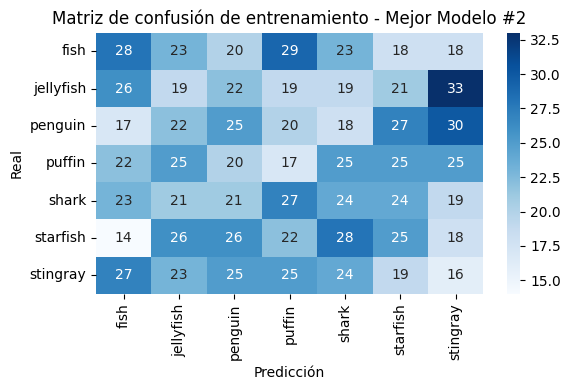

In [40]:
# Dibujamos la matriz de confusión del conjunto de entrenamiento del mejor modelo seleccionado
# Paso 1: Predicciones del modelo
y_pred_probs_train = best_model.predict(train_dataset)
y_pred_train = np.argmax(y_pred_probs_train, axis=1)

# Paso 2: Etiquetas reales extraídas del dataset
y_true_train = []
for _, labels in train_dataset:
    y_true_train.extend(np.argmax(labels.numpy(), axis=1))
y_true_train = np.array(y_true_train)

# Paso 3: Obtener nombres de clase
class_names = train_dataset.class_names

# Paso 4: Matriz de confusión
cm = confusion_matrix(y_true_train, y_pred_train)

# Paso 5: Dibujar la matriz
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title(f"Matriz de confusión de entrenamiento - Mejor Modelo #{best_index+1}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

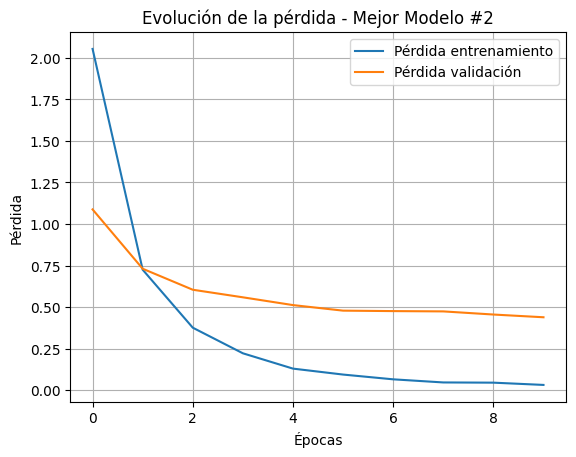

In [42]:
# Dibujamos un gráfico que muestra la variación de la pérdida en función de las épocas para el conjunto de entrenamiento del mejor modelo.
plt.plot(best_history.history['loss'], label='Pérdida entrenamiento')
plt.plot(best_history.history['val_loss'], label='Pérdida validación')
plt.title(f"Evolución de la pérdida - Mejor Modelo #{best_index+1}")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Métricas de evaluación en datos de test para el Modelo:
Accuracy: 0.8613
Precision: 0.8620
Recall: 0.8613
F1-Score: 0.8549




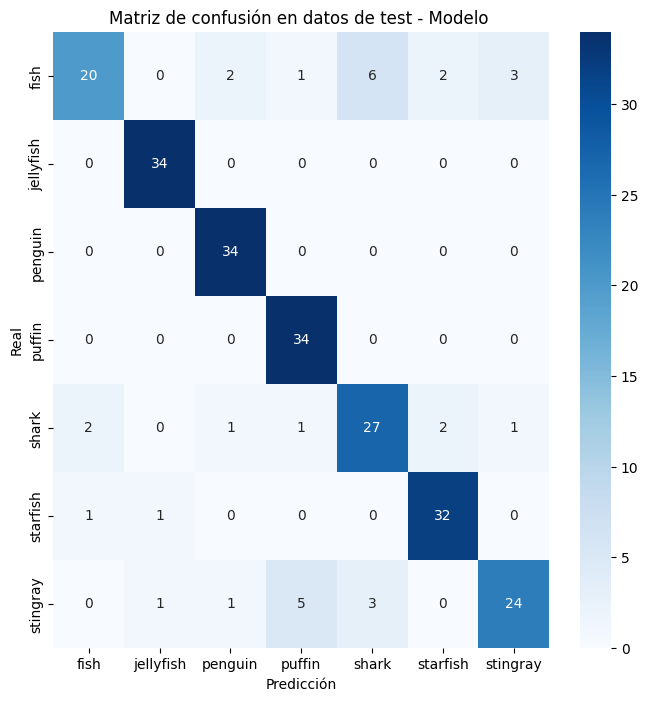

Informe de clasificación detallado por clase:
              precision    recall  f1-score   support

        fish       0.87      0.59      0.70        34
   jellyfish       0.94      1.00      0.97        34
     penguin       0.89      1.00      0.94        34
      puffin       0.83      1.00      0.91        34
       shark       0.75      0.79      0.77        34
    starfish       0.89      0.94      0.91        34
    stingray       0.86      0.71      0.77        34

    accuracy                           0.86       238
   macro avg       0.86      0.86      0.85       238
weighted avg       0.86      0.86      0.85       238



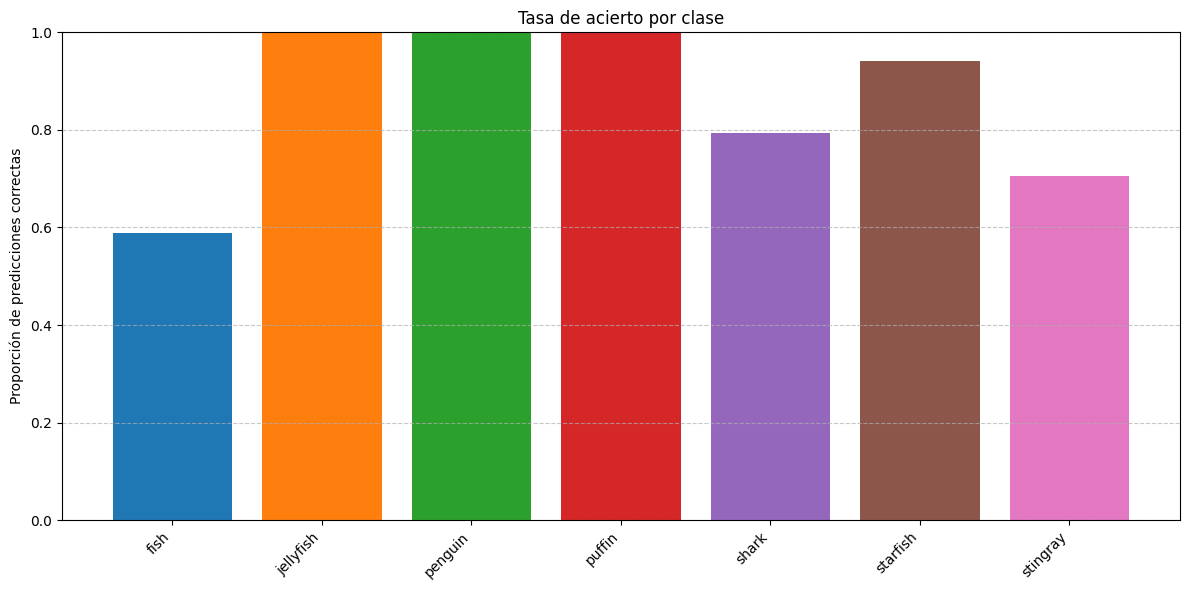

In [43]:
# Realizamos predicciones sobre el conjunto de test
y_pred_probs_test = best_model.predict(test_dataset)
y_pred_test = np.argmax(y_pred_probs_test, axis=1)

# Extraemos las etiquetas reales del test_dataset
y_true_test = []
for _, labels in test_dataset:
    y_true_test.extend(np.argmax(labels.numpy(), axis=1))
y_true_test = np.array(y_true_test)

# Nombres de clases
class_names = test_dataset.class_names

# Calculamos métricas básicas
accuracy = accuracy_score(y_true_test, y_pred_test)
precision = precision_score(y_true_test, y_pred_test, average='weighted')
recall = recall_score(y_true_test, y_pred_test, average='weighted')
f1 = f1_score(y_true_test, y_pred_test, average='weighted')

# Mostramos las métricas
print(f"Métricas de evaluación en datos de test para el Modelo:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n")

# Matriz de confusión
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title(f"Matriz de confusión en datos de test - Modelo ")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Informe por clase
print("Informe de clasificación detallado por clase:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))

# Visualización de la distribución de predicciones por clase
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(class_names):
    class_indices = np.where(y_true_test == i)[0]
    correct_preds = sum(y_pred_test[class_indices] == i)
    plt.bar(i, correct_preds / len(class_indices) if len(class_indices) > 0 else 0)

plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.ylim(0, 1)
plt.title("Tasa de acierto por clase")
plt.ylabel("Proporción de predicciones correctas")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
